# The transformer architecture

The transformer architecture describes an Encoder (left) and Decoder (right).

<img src="assets/transformer.png" alt="Image" style="width:20%; display: block; margin: 0 auto;"/>

## Encoder
- Encodes words or word-tokens to vectors. One input word/token results in one output word/token vector.
- All words are simultaniously passed into the encoder. This has several advantages e.g., usage of parallelization on GPUs and better captioning of word meaning through the attention block.

#### Encoder Blocks
- Input Embedding: Some vector embedding of each word.
- Positional Encoding: Encoding of each word with respect to the position of the word in a sentence.
- Input Embedding and Positional Encoding forms the Input to the Encoder Block.
- Multi-Head Attention: Every single word has 3 vectors: Q, K and V. More explanation below. "Multi" because we can stack the results on top of each other to get multi-attention. 
    - Q = What I am looking for [sequence length x d<sub>k</sub>].
    - K = What I can offer [sequence length x d<sub>k</sub>]
    - V: What I actually offer [sequence length x d<sub>v</sub>]
- Feed Forward:
- Add & Norm:

## Decoder
- The decoder first takes in the output of the encoder and a start token.
- Then it will start generating the first word e.g. a translated word.
- The translated word is then taken as an input for the decoder to generate the next word until the end of the sequence.

### Attention (Single Attention Head Logic)

In [1]:
import numpy as np
import math

In [2]:
sequence_length, d_k, d_v = 4, 8, 8
q = np.random.randn(sequence_length, d_k) # creates 8 x 1 vectors for each word in the sequence
k = np.random.randn(sequence_length, d_k) # creates 8 x 1 vectors for each word in the sequence
v = np.random.randn(sequence_length, d_v) # creates 8 x 1 vectors for each word in the sequence

In [3]:
print("q:", q)
print("k:", k)  
print("v:", v)

q: [[ 0.86868105  0.08988912 -1.10323393  0.93144423 -0.22112637 -0.24831209
   0.40688423 -0.91289303]
 [ 0.40834656  0.50665297  0.4314858   0.53812964 -0.16228728  1.2091965
   0.32464194  1.24150235]
 [-1.4595666   0.42829345 -2.01205567 -0.54580935 -0.25461517  0.45080158
   0.97421065 -0.31558105]
 [ 0.0123245   0.15119283  0.47036     0.82814215 -0.77944948  0.22135308
  -0.05344812 -0.17976496]]
k: [[-0.14663854  0.17277554  0.52508051 -0.9774565   0.67674323  2.12405684
   1.9797991   0.25068627]
 [ 0.62117261 -0.01769471  0.62455526  0.63756487  0.45165196  0.40678757
   0.2247856   0.61074585]
 [ 0.98421635 -0.08212173 -0.52603783 -0.51968416  0.03170745  0.77673048
  -0.09899019 -0.26064771]
 [-0.00777449 -0.3075334   0.35970135  1.77996769  1.26058828 -1.26232102
  -0.67460475 -0.19517895]]
v: [[-0.06308092 -0.65323852 -0.31715511  0.02395267 -0.30154605  0.90656808
  -0.71534914 -0.52487617]
 [-1.90357465  1.51662128  0.37612027  0.15376715  1.36739678 -1.5665135
  -0.196

## Self-Attention

<img src="assets/attention.png" alt="Image" style="width:20%; display: block; margin: 0 auto;"/>


$$
\text{Self-Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

In [4]:
# create an initial attention matrix, we need every word to look at every word to look at every other word 
np.matmul(q, k.T) # 4 x 4 matrix

array([[-1.70195981, -0.22413047,  0.94165722,  1.16510018],
       [ 3.14075306,  2.1070739 ,  0.43200179, -1.23821972],
       [ 2.39988965, -2.4242184 ,  0.19826067, -3.30126287],
       [-0.74638268,  0.44293921, -0.47872225,  0.40582191]])

In [5]:
scaled = np.matmul(q, k.T) / math.sqrt(d_k) # scale by square root of d_k
scaled

array([[-0.60173366, -0.07924209,  0.3329261 ,  0.41192512],
       [ 1.11042389,  0.74496312,  0.1527357 , -0.43777678],
       [ 0.84848912, -0.85709064,  0.07009573, -1.16717268],
       [-0.26388613,  0.15660266, -0.16925388,  0.14347971]])

## Masking
- This is to ensure words don't get context from words generated in the future
- Not requred in the encoders, but reqiured in the decoders

In [6]:
mask = np.tril(np.ones((sequence_length, sequence_length)))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [7]:
mask[mask == 0] = -np.infty
mask[mask == 1.0] = 0
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [8]:
scaled + mask

array([[-0.60173366,        -inf,        -inf,        -inf],
       [ 1.11042389,  0.74496312,        -inf,        -inf],
       [ 0.84848912, -0.85709064,  0.07009573,        -inf],
       [-0.26388613,  0.15660266, -0.16925388,  0.14347971]])

## Softmax
- Is used to convert a vector into a probability distribution
- Advantage: Values add up to one and are more interpretable

$$
\text{softmax}(x) = \frac{e^{x_i}}{\sum_j e_j^x}
$$



In [9]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1).T

In [10]:
attention = softmax(scaled + mask)
attention

array([[1.        , 0.        , 0.        , 0.        ],
       [5.54090339, 0.40963831, 0.        , 0.        ],
       [4.26406437, 0.08253487, 0.27982707, 0.        ],
       [1.40192674, 0.2274463 , 0.22026298, 0.29325041]])

In [11]:
# multiplie attention matrix with value matrix
new_v = np.matmul(attention, v)
new_v # new matrix which should encapsulate the context of a word better

array([[-0.06308092, -0.65323852, -0.31715511,  0.02395267, -0.30154605,
         0.90656808, -0.71534914, -0.52487617],
       [-1.12930238, -2.99826537, -1.60325255,  0.19570834, -1.1106994 ,
         4.3815022 , -4.04409616, -2.57626344],
       [-0.69959256, -2.45299337, -1.55303486,  0.50810972, -1.4597372 ,
         3.27639529, -2.49244182, -1.86199652],
       [-0.77922197, -0.34952881, -0.49471635,  0.08884478, -0.17372499,
         0.69091375, -0.57120287, -0.65999148]])

In [12]:
v

array([[-0.06308092, -0.65323852, -0.31715511,  0.02395267, -0.30154605,
         0.90656808, -0.71534914, -0.52487617],
       [-1.90357465,  1.51662128,  0.37612027,  0.15376715,  1.36739678,
        -1.5665135 , -0.19630905,  0.81053136],
       [-0.97739   ,  0.74075609, -0.82804033,  1.40544962, -1.02485925,
        -1.64379155,  2.05146446,  1.10501159],
       [-0.14507501,  0.19830393,  0.15942467, -0.9864518 ,  0.55839545,
         0.47173279,  0.0833837 , -1.19999508]])

## Multi-head Attention
- Takes a vector (e.g. 512x1) which breaks down into three vectors (Q, K and V). 
- These three vectors are broken up into separate pieces e.g. 8 pieces for 8 attention heads
- Each of these pieces is fed into an **Attention Unit** with all the other words too
- This genereates an attention matrix for each head which is of size sequence length to sequence length. Moreover all rows add up to one, because its a probability distribution.
- This generates other output vectors that get concatenated, which generates a vector with very good contextual awareness


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
sequence_length = 4 # length of input sentence with fixed max size
batch_size = 1 
input_dim = 512 # vector dimension of every word that goes into the attention unit 
d_model = 512 # output of the attention unit for every word
x = torch.randn(batch_size, sequence_length, input_dim) # input embedding randomly generated from a normal distribution

In [16]:
x.size()

torch.Size([1, 4, 512])

Mapping of the input dimension to the Q, K and V vectors.

In [17]:
qkv_layer = nn.Linear(input_dim, d_model * 3) # linear layer to generate q, k, v vectors all concatenated together, which all have 8 attention heads

In [19]:
qkv = qkv_layer(x)

In [21]:
qkv.shape

torch.Size([1, 4, 1536])

That is 1 batch, 4 words, with each word vector being 1536 in size.

In [26]:
qkv[0] # this is the batch

tensor([[ 0.5720, -0.4355, -0.6658,  ...,  0.3326,  0.1917,  0.3432],
        [ 0.7264, -1.0669, -0.4281,  ..., -0.9502, -1.2488, -0.8482],
        [ 0.5239, -0.8063, -0.5243,  ...,  0.3656, -0.0138, -0.7699],
        [ 0.5537, -0.0665, -0.8164,  ...,  0.1043, -0.2839,  0.6794]],
       grad_fn=<SelectBackward0>)

In [28]:
qkv[0][0] # this is the vector of the batch and the first word

tensor([ 0.5720, -0.4355, -0.6658,  ...,  0.3326,  0.1917,  0.3432],
       grad_fn=<SelectBackward0>)

Text(0.5, 1.0, 'qkv distribution')

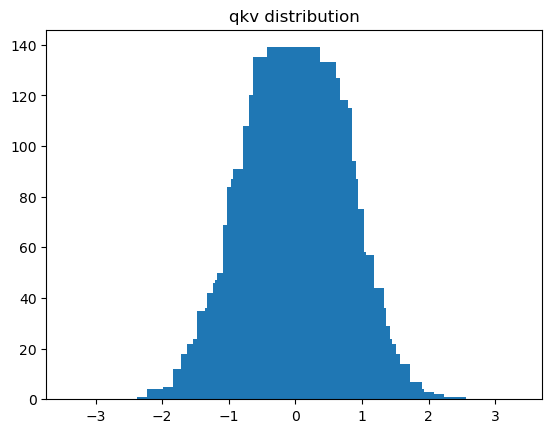

In [34]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center')
plt.title('qkv distribution')

In [47]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim) # breaks down last dimension into a product of num_heads and 3 * head_dim

In [56]:
(512 // 8) * 3 # 3 for q, k, v

192

In [48]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [61]:
qkv[0][0][0].size() # first batch, first word, first attention head with all q, k, v vectors concatenated, each being of size 64

torch.Size([192])

In [62]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [63]:
q, k, v = qkv.chunk(3, dim=-1) # splits the last dimension into 3 chunks, each of size 64
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## Self-Attention for multiple heads

For a single head:

$$
\text{Self-Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}} + M\right)
$$
$$
\text{new V} = \text{Self-Attention. V}
$$

Every word has a query vector and it is going to compare itslef to one of its key vectors i.e. the matrix multiplication of 
$$QK^T$$
We scale this by 
$$\sqrt{d_k}$$ 
to make sure that the variance of the values is much smaller.

In [64]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k) # transpose along the sequence length and the dimension size (head_dim) scaled by square root of d_k
scaled.shape # sequence_length x sequence_length

torch.Size([1, 8, 4, 4])

In [65]:
k.T.shape # sequence_length x sequence_length

torch.Size([64, 4, 8, 1])

In [67]:
mask = torch.full(scaled.size(), float('-inf')) # create a matrix of negative infinity
mask = torch.triu(mask, diagonal=1) # create a upper triangular matrix of negative infinity
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [68]:
(scaled + mask)[0][0]

tensor([[ 0.0676,    -inf,    -inf,    -inf],
        [-0.0658, -0.1217,    -inf,    -inf],
        [-0.1628, -0.7305,  0.0187,    -inf],
        [-0.2241, -0.3892,  0.3594,  0.0204]], grad_fn=<SelectBackward0>)

In [69]:
scaled += mask

In [70]:
attention = F.softmax(scaled, dim=-1) # softmax along the last dimension

In [71]:
attention.shape

torch.Size([1, 8, 4, 4])

In [72]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5140, 0.4860, 0.0000, 0.0000],
        [0.3615, 0.2049, 0.4335, 0.0000],
        [0.2034, 0.1724, 0.3645, 0.2597]], grad_fn=<SelectBackward0>)

In [74]:
values = torch.matmul(attention, v) # multiply attention with v (what is offered by every single word)
values.shape

torch.Size([1, 8, 4, 64])

In [75]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim) # concatenate all the heads together
values.shape

torch.Size([1, 4, 512])

In [76]:
linear_layer = nn.Linear(d_model, d_model) # linear layer to transform the concatenated heads into the output dimension to 512 x 512

In [77]:
out = linear_layer(values)

In [78]:
out.shape

torch.Size([1, 4, 512])

In [80]:
out # new vectors for each word of a sequence which should be more context aware than the original vector

tensor([[[-0.2428,  0.2622,  0.1467,  ...,  0.1397, -0.1031,  0.3395],
         [-0.2548, -0.0433,  0.1523,  ...,  0.3486, -0.2958, -0.2404],
         [ 0.0026, -0.3175, -0.0807,  ..., -0.3405,  0.3318,  0.1761],
         [-0.3646, -0.1380,  0.1150,  ..., -0.5668,  0.0620, -0.1288]]],
       grad_fn=<ViewBackward0>)

## Positional Encoding

- Inital part of the transformer neural network architecture
- Take the sequence and pad the rest to the max allowed sequence length of the network
- Each word is one-hot encoded, where vocab size is the number of words in the dictionary (all possible words that can be used as input)
- This is passed into a feed-forward layer where each of these vectors is mapped to a 512 dimensional vector. Parameters are learnable via backpropagation.
- Output is a set of 512 dimensional vectors for each input in the sequence
- To the output a set of positional encoded vectors is added, which then forms the input into the next steps of the transformer network

<img src="assets/positional_encoding.png" alt="Image" style="width:20%; display: block; margin: 0 auto;"/>

- i = dimension index
- d_model = Embedding Length
- pos = position of word in sequence

In [81]:
max_sequence_length = 10
d_model = 6

In [89]:
even_i = torch.arange(0, d_model, 2).float() # set of values between 0 and d_model with a step size of 2
even_i

tensor([0., 2., 4.])

In [90]:
even_denominator = torch.pow(10000, even_i / d_model)
even_denominator

tensor([  1.0000,  21.5443, 464.1590])

In [87]:
odd_i = torch.arange(1, d_model, 2).float()
odd_i

tensor([1., 3., 5.])

In [88]:
odd_denominator = torch.pow(10000, (odd_i -1) / d_model)
odd_denominator

tensor([  1.0000,  21.5443, 464.1590])

In [91]:
denominator = even_denominator

In [92]:
position = torch.arange(max_sequence_length, dtype=torch.float).reshape(max_sequence_length, 1)

In [93]:
position

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [94]:
even_PE = torch.sin(position / denominator)
odd_PE = torch.cos(position / denominator)

In [95]:
even_PE

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086],
        [-0.9589,  0.2300,  0.0108],
        [-0.2794,  0.2749,  0.0129],
        [ 0.6570,  0.3192,  0.0151],
        [ 0.9894,  0.3629,  0.0172],
        [ 0.4121,  0.4057,  0.0194]])

In [96]:
stacked = torch.stack((even_PE, odd_PE), dim=2)
stacked.shape

torch.Size([10, 3, 2])

In [97]:
PE = torch.flatten(stacked, start_dim=1, end_dim=2)
PE

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

## Layer Normalization (Add & Norm)

- Adds the initial embedding (to counteract vanishing gradients during backpropagation) and the output of the attention block and normalizes the result
- Normalization: Encapsulates values within smaller range centering around zero --> more even steps in gradient descent, faster and more stable to get to optimal parameter values
- Layer: Strategy of Normalization, meaning that all activation values in every layer is normalized such that all values in a layer center around zero and have a standard deviation of about 1
